# Creating a course recommendation system using unsupervised learning - Course Similarity

## Notebook Summary:

- The code uses the course_genre dataframe, the rs_content_test dataframe the and similarity matrix csv to generate recommendations for users based on similarities between courses.
- The generate_recommendations_for_one_user function takes in a user's enrolled and unselected courses, along with similarity scores between courses, and returns recommended courses for that user.
- The generate_recommendations_for_all function loops through all the users in the dataset and generates recommendations for each one using generate_recommendations_for_one_user.
- The compute_silhouette_score function calculates the similarity between recommended courses for each user and returns a score that measures how well the recommendations fit with the user's interests.
- The code saves the recommendations for all users, along with their associated scores, into a dataframe called res_df.
- The silhouette score is printed out at the end, indicating how well the recommendations fit with the user's interests on average.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns

#The suppression is used as there will be instances where no recommendations are generated due to the threshold value

import warnings

def suppress_warnings():
    warnings.filterwarnings("ignore")

warnings.filterwarnings("ignore", message="Mean of empty slice.", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars", category=RuntimeWarning)


In [2]:
# Test user dataframe
test_users_df = pd.read_csv('rs_content_test.csv')
# Course similarity matrix
sim_df = pd.read_csv('sim.csv')
# Course content dataframe
course_genre_df = pd.read_csv('course_genre.csv')

In [3]:
# Get test user ids
test_users = test_users_df.groupby(['user']).max()
test_user_ids = test_users.index.tolist()

In [4]:
def generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix, threshold):
    """
    Generate course recommendations for one user based on their enrolled and unselected courses.

    Args:
        enrolled_course_ids (list): List of course IDs the user has already enrolled in.
        unselected_course_ids (list): List of course IDs the user has not yet selected.
        id_idx_dict (dict): Dictionary mapping course IDs to their indices in the sim_matrix.
        sim_matrix (list): 2D list containing pairwise similarity scores between courses.
        threshold (float): Similarity threshold to filter out courses.

    Returns:
        dict: A dictionary mapping recommended course IDs to their similarity scores.
    """
    # Initialize an empty dictionary to store recommended courses and their similarity scores
    res = {}

    # Iterate over all combinations of enrolled and unselected courses
    for enrolled_course in enrolled_course_ids:
        for unselect_course in unselected_course_ids:
            # Check if both courses are present in the sim_matrix
            if enrolled_course in id_idx_dict and unselect_course in id_idx_dict:
                # Get the indices of the enrolled and unselected courses in the sim_matrix
                enrolled_course_idx = id_idx_dict[enrolled_course]
                unselect_course_idx = id_idx_dict[unselect_course]

                # Get the similarity score between the enrolled and unselected courses from the sim_matrix
                sim = sim_matrix[enrolled_course_idx][unselect_course_idx]

                # Check if the similarity score is above the threshold
                if sim > threshold:
                    # Add the unselected course and its similarity score to the recommendations dictionary
                    if unselect_course not in res:
                        res[unselect_course] = sim
                    else:
                        if sim >= res[unselect_course]:
                            res[unselect_course] = sim

    # Sort the recommendations dictionary by descending similarity scores and return it
    res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}
    return res


In [5]:
def generate_recommendations_for_all(test_users_df, test_user_ids, course_df, sim_df, threshold):
    """
    Generate course recommendations for a list of test users.

    Args:
        test_users_df (pandas.DataFrame): A DataFrame containing the user-item interactions for test users.
        test_user_ids (list): A list of user IDs for whom to generate recommendations.
        course_df (pandas.DataFrame): A DataFrame containing information about all available courses.
        sim_df (pandas.DataFrame): A DataFrame containing the pairwise similarity scores between all courses.
        threshold (float): A threshold value for the similarity scores. Only courses with similarity scores above this value will be recommended.

    Returns:
        A tuple of three lists:
            1. A list of user IDs.
            2. A list of recommended courses for each user.
            3. A list of similarity scores for the recommended courses for each user.
    """
    
    # Initialize empty lists to store results
    users = []
    courses = []
    sim_scores = []
    
    # Create a dictionary mapping course IDs to their index in the course_df DataFrame
    id_idx_dict = {course_id: i for i, course_id in enumerate(course_df['COURSE_ID'])}
    
    # Convert the sim_df DataFrame to a list of lists
    sim_matrix = sim_df.values.tolist()

    # Loop through each test user and generate recommendations
    for user_id in test_user_ids:
        users.append(user_id)
        
        # Get the list of courses the user has already enrolled in
        enrolled_courses = test_users_df.loc[test_users_df['user'] == user_id, 'item'].tolist()
        
        # Get the list of courses the user has not yet enrolled in
        unselected_courses = set(course_df['COURSE_ID']) - set(enrolled_courses)
        
        # Generate recommendations for the user
        recommendations = generate_recommendations_for_one_user(enrolled_courses, unselected_courses, id_idx_dict, sim_matrix, threshold)
        
        # Convert the recommendations dictionary to separate lists of course IDs and similarity scores
        recommended_courses = list(recommendations.keys())
        recommended_scores = list(recommendations.values())
        
        # Append the recommended courses and similarity scores to the courses and sim_scores lists
        courses.append(recommended_courses)
        sim_scores.append(recommended_scores)

    # Return the final results as a tuple
    return users, courses, sim_scores


In [6]:
def compute_silhouette_score(courses, sim_scores):
    """
    Computes the silhouette score for a set of courses based on their similarity scores.

    Parameters
    ----------
    courses : list
        A list of course names.
    sim_scores : numpy.ndarray
        A 2D numpy array containing the similarity scores between each pair of courses.

    Returns
    -------
    float
        The average silhouette score for the set of courses.
    """
    # Calculate the average similarity score for each course
    avg_sim_scores = []
    for i, course in enumerate(courses):
        avg_sim_scores.append(np.mean(sim_scores[i]))

    # Calculate the silhouette score for each course
    silhouette_scores = []
    for i, course in enumerate(courses):
        # Check if there are any recommendations for this course
        if len(sim_scores[i]) == 0:
            continue
        
        # Calculate the difference between the average similarity score of the current course and each other course
        diff = []
        for j, other_course in enumerate(courses):
            if i != j and len(sim_scores[j]) > 0:
                diff.append(abs(avg_sim_scores[i] - avg_sim_scores[j]))

        # Calculate the silhouette score for the current course
        if len(diff) > 0:
            silhouette_scores.append(max(diff) / (avg_sim_scores[i] + np.min(diff)))

    # Return the average silhouette score for all courses -> use nanmean to avoid a divide-by-zero error
    return np.nanmean(silhouette_scores)


In [7]:
# Results dictionary and results dataframe -> threshold = 0.6
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all(test_users_df, test_user_ids, course_genre_df, sim_df, threshold = 0.6)
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])

# View results dataframe
res_df

,USER,COURSE_ID,SCORE
0,37465,"[DS0110EN, excourse67, excourse63, excourse72,...","[0.7329409123199365, 0.7082138557765277, 0.694..."
1,50348,"[CB0101EN, DS0110EN, CL0101EN, excourse67, exc...","[0.9233805168766388, 0.7329409123199365, 0.732..."
2,52091,"[ML0120ENv3, CB0101EN, excourse24, excourse36,...","[1.0, 0.9233805168766388, 0.7526312050490548, ..."
3,70434,"[excourse67, excourse72, excourse74, excourse68]","[0.7082138557765277, 0.7036476305124202, 0.650..."
4,85625,"[TMP0101EN, excourse72, TA0105EN, BD0151EN, BD...","[0.8894991799933215, 0.7036476305124202, 0.659..."
...,...,...,...
995,2061096,"[DS0110EN, excourse67, excourse63, excourse72,...","[0.7329409123199365, 0.7082138557765277, 0.694..."
996,2074313,"[excourse36, excourse23, DS0110EN, DV0151EN, e...","[0.7397041774816828, 0.7397041774816828, 0.732..."
997,2074462,"[CL0101EN, excourse62, excourse22, excourse24]","[0.7327907262791404, 0.6475015976638527, 0.647..."
998,2082818,"[DV0151EN, ML0115EN, ML0122EN]","[0.7235359517703827, 0.7071067811865475, 0.681..."


In [8]:
# Compute silhouette_score
silhouette_score = compute_silhouette_score(courses, sim_scores)
silhouette_score

c:\Users\ikram\anaconda3\envs\py10\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.46237152419787053

In [9]:
# Results dictionary and results dataframe -> threshold = 0.4
res_dict_2 = {}
users, courses, sim_scores = generate_recommendations_for_all(test_users_df, test_user_ids, course_genre_df, sim_df, threshold = 0.4)
res_dict_2['USER'] = users
res_dict_2['COURSE_ID'] = courses
res_dict_2['SCORE'] = sim_scores
res_df_2 = pd.DataFrame(res_dict_2, columns=['USER', 'COURSE_ID', 'SCORE'])

# View results dataframe
res_df_2

,USER,COURSE_ID,SCORE
0,37465,"[DS0110EN, excourse67, excourse63, excourse72,...","[0.7329409123199365, 0.7082138557765277, 0.694..."
1,50348,"[CB0101EN, DS0110EN, CL0101EN, excourse67, exc...","[0.9233805168766388, 0.7329409123199365, 0.732..."
2,52091,"[ML0120ENv3, CB0101EN, excourse24, excourse36,...","[1.0, 0.9233805168766388, 0.7526312050490548, ..."
3,70434,"[excourse67, excourse72, excourse74, excourse6...","[0.7082138557765277, 0.7036476305124202, 0.650..."
4,85625,"[TMP0101EN, excourse72, TA0105EN, BD0151EN, BD...","[0.8894991799933215, 0.7036476305124202, 0.659..."
...,...,...,...
995,2061096,"[DS0110EN, excourse67, excourse63, excourse72,...","[0.7329409123199365, 0.7082138557765277, 0.694..."
996,2074313,"[excourse36, excourse23, DS0110EN, DV0151EN, e...","[0.7397041774816828, 0.7397041774816828, 0.732..."
997,2074462,"[CL0101EN, excourse62, excourse22, excourse24,...","[0.7327907262791404, 0.6475015976638527, 0.647..."
998,2082818,"[DV0151EN, ML0115EN, ML0122EN, SC0103EN, TMP01...","[0.7235359517703827, 0.7071067811865475, 0.681..."


In [10]:
silhouette_score_2 = compute_silhouette_score(courses, sim_scores)
silhouette_score_2

0.38262685983873995

In [11]:
# Results dictionary and results dataframe -> threshold = 0.2
res_dict_3 = {}
users, courses, sim_scores = generate_recommendations_for_all(test_users_df, test_user_ids, course_genre_df, sim_df, threshold = 0.2)
res_dict_2['USER'] = users
res_dict_2['COURSE_ID'] = courses
res_dict_2['SCORE'] = sim_scores
res_df_2 = pd.DataFrame(res_dict_2, columns=['USER', 'COURSE_ID', 'SCORE'])

# View results dataframe
res_df_2

,USER,COURSE_ID,SCORE
0,37465,"[DS0110EN, excourse67, excourse63, excourse72,...","[0.7329409123199365, 0.7082138557765277, 0.694..."
1,50348,"[CB0101EN, DS0110EN, CL0101EN, excourse67, exc...","[0.9233805168766388, 0.7329409123199365, 0.732..."
2,52091,"[ML0120ENv3, CB0101EN, excourse24, excourse36,...","[1.0, 0.9233805168766388, 0.7526312050490548, ..."
3,70434,"[excourse67, excourse72, excourse74, excourse6...","[0.7082138557765277, 0.7036476305124202, 0.650..."
4,85625,"[TMP0101EN, excourse72, TA0105EN, BD0151EN, BD...","[0.8894991799933215, 0.7036476305124202, 0.659..."
...,...,...,...
995,2061096,"[DS0110EN, excourse67, excourse63, excourse72,...","[0.7329409123199365, 0.7082138557765277, 0.694..."
996,2074313,"[excourse36, excourse23, DS0110EN, DV0151EN, e...","[0.7397041774816828, 0.7397041774816828, 0.732..."
997,2074462,"[CL0101EN, excourse62, excourse22, excourse24,...","[0.7327907262791404, 0.6475015976638527, 0.647..."
998,2082818,"[DV0151EN, ML0115EN, ML0122EN, SC0103EN, TMP01...","[0.7235359517703827, 0.7071067811865475, 0.681..."


In [12]:
silhouette_score_3 = compute_silhouette_score(courses, sim_scores)
silhouette_score_3

0.3490194951214376

[]

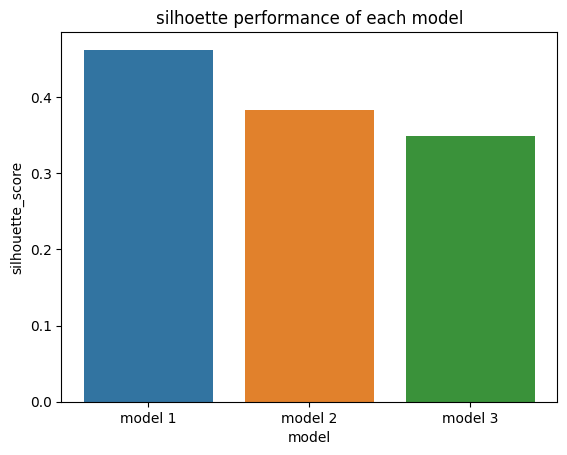

In [13]:
silhoette_score_list = [silhouette_score, silhouette_score_2, silhouette_score_3]
model_labels = ['model 1', 'model 2', 'model 3']


# create a dataframe with the values and names
df_sil = pd.DataFrame({'silhouette_score': silhoette_score_list, 'model': model_labels})

# use seaborn to plot the bar chart
sns.barplot(x='model', y='silhouette_score', data=df_sil)
plt.title('silhoette performance of each model')
plt.plot()